# Simplified mixture model for UHECR data

A generative model is built here to simulate datasets and test the fit for known parameters. 

In [1]:
%matplotlib inline
import sys
sys.path.append('../../')
from matplotlib import pyplot as plt
import numpy as np
import pystan
from fancy import *

In [2]:
# read in relevant data
source_file = '../data/agn_catalog.dat'

# define a Data() instance to handle all data
data = Data()

# add the AGN data
data.add_source(source_file, 'AGN')

## Sources

For the most basic model start with just the sources and propagation with no detection effects. The source distribution is defined by the luminosity function $(F_T, f)$ and the hyperparameters $s$, $a$ and $b$:

<div><center>
$ g(F_T) = \frac{1}{s}e^{-F_T/s}$
<center></div>
<div><center>
$ h(f) = \frac{1}{B(a,b)}f^{a-1}(1-f)^{b-1}$
<center></div>

With s = $0.01 \times 4\pi$, and a = b = 1.
We have the *luminosity function* of a standard candle: $F_k = I/D_k^2$, but we choose instead to represent I through the total source flux: $ F_A = \sum_{k=1}^{N_A} $. So, $F_k = w_kF_A$ with the weights $w_k = \frac{1/D_k^2}{\sum_{j=1}^{N_A} 1/D_j^2}$. 

For now we set the total integrated flux to 500 events, to be distributed amongst the sources depending on their distance from Earth, with a fraction from isotropic background.

The associated fraction is 0.6, so 0.4 of $F_T$ is simulated form an isotropic background.

To summarise, we have:

* $F_T = 500$
* $f = 0.6$

In [3]:
# set source parameters
F_T = 200 # total flux
f = 0.7 # associated fraction
F_A = f * F_T # source flux

In [4]:
# use this model to generate simulated data from the given AGN sources
# distances to AGN
D = data.source['AGN'].distance

# number of AGN
N_A = len(D) 

# function to calculate the weights
def get_weights(D, f):
    normalisation = 0
    for D_j in D:
        normalisation += (1 / D_j**2)  
    
    w = []
    for D_k in D:
        w.append( (1 / D_k**2) / normalisation)
    w = np.asarray(w)
    # scale to f
    w = w * f
    return w

# how many events to simulate for each source?
w = get_weights(D, f)
F = []
for w_k in w:
    F.append(int(round(w_k * F_T)))
print ('Total source flux:', sum(F))
print ('f * F_T:', f * F_T)

Total source flux: 139
f * F_T: 140.0


In [5]:
from astropy.coordinates import SkyCoord
from astropy import units as u

# Make a wapper class to store output
class Direction():
    """
    Input the unit vector vMF samples and 
    store x, y, and z and galactic coordinates 
    of direction in Mpc.
    
    :param omega_k: unit vector
    :param norm: unit vector = vector / norm
    """
    
    def __init__(self, omega_k, norm):
        self.unit_vector = omega_k 
        self.norm = norm
        self.x = np.transpose(omega_k)[0] * self.norm
        self.y = np.transpose(omega_k)[1] * self.norm
        self.z = np.transpose(omega_k)[2] * self.norm
        self.d = SkyCoord(self.x, self.y, self.z, 
                          unit = 'mpc', 
                          representation_type = 'cartesian', 
                          frame = 'galactic')
        self.d.representation_type = 'spherical'
        self.lons = self.d.galactic.l.wrap_at(360 * u.deg).deg
        self.lats = self.d.galactic.b.wrap_at(180 * u.deg).deg

In [6]:
# simulate the isotropic background

F_bg = F_T - sum(F)
print ('Total background flux:', F_bg)

def sample_unit_sphere(n_samples):
    # unit sphere
    r = 1

    u = np.random.uniform(0, 1, n_samples)
    v = np.random.uniform(0, 1, n_samples)
    theta = 2 * np.pi * u
    phi = np.arccos(2 * v - 1)

    # convert to cartesian and norm
    x = r * np.cos(theta) * np.sin(phi) 
    y = r * np.sin(theta) * np.sin(phi) 
    z = r * np.cos(phi) 
    return np.transpose([x, y, z])

background = Direction(sample_unit_sphere(F_bg), norm = 1)

Total background flux: 61


## Propagation

Due to magnetic fields, the UHECR trajectories are deflected. For a simple model, this deflection can de described by a von Mises - Firsher distribution:

<div><center>
$\rho_k(\omega | \kappa) = \frac{\kappa}{4\pi sinh(\kappa)}e^{\kappa \omega . \varpi_k}$    
<center></div>

Where:

* $\kappa$ is the concentration parameter
* $\omega$ is the UHECR direction
* $\varpi_k$ is the source direction

Here, we set the concentration parameter to be $\kappa = 100$

In [7]:
# set the propagation parameter
kappa = 100

In [9]:
sys.path.append('../')
from vMF import *

# Now try with the vMF distribution 
# get the positions of the sources
skycoords = data.source['AGN'].coord

# convert to cartesian coordinates
varpi = [skycoords.cartesian.x, skycoords.cartesian.y, skycoords.cartesian.z] 
varpi = np.transpose(varpi)
        
# simulate events
omega = []
mus = []
for i in range(N_A):
    N = F[i]
    # normalise to unit sphere for sampling, then revert
    norm = np.linalg.norm(varpi[i])
    mu = varpi[i] / norm
    mus.append(Direction(mu, norm))
    omega_k = (sample_vMF(mu, kappa, N))
    omega.append(Direction(omega_k, norm))

/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


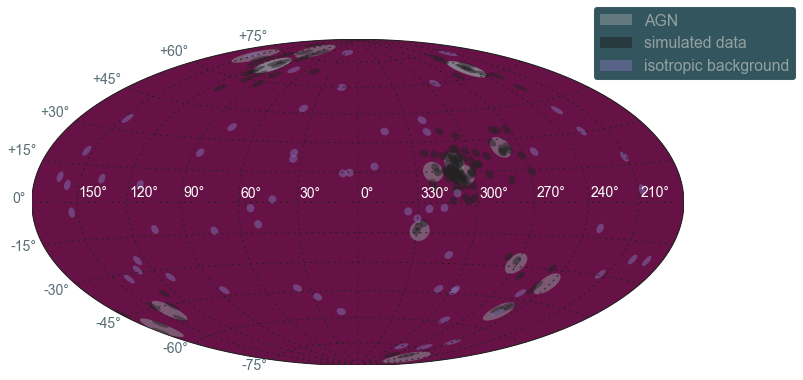

In [10]:
# plot the results on a skymap
# sources
fig, skymap = data.show()
# simulated data
label = True
for o in omega:
    for lon, lat in np.nditer([o.lons, o.lats]):
        if label:
            skymap.tissot(lon, lat, 2, npts = 30, facecolor = 'k', alpha = 0.5, 
                          label = 'simulated data')
            label = False
        else:
            skymap.tissot(lon, lat, 2, npts = 30, facecolor = 'k', alpha = 0.5)
# simulated background
label = True
for lon, lat in np.nditer([background.lons, background.lats]): 
    if label:
        skymap.tissot(lon, lat, 2, npts = 30, facecolor = 'm', alpha = 0.5, 
                      label = 'isotropic background')
        label = False
    else:
       skymap.tissot(lon, lat, 2, npts = 30, facecolor = 'm', alpha = 0.5)  
   
plt.gca()
plt.legend(bbox_to_anchor=(0.85, 0.85))

## Detection effects

The arrival direction of UHECR is reconstructed with a certain uncertainty by the PAO team. This is quantified here by the von Mises-Fisher distribution for the data:

<div><center>
$P(d_i | \omega_i) = \frac{\kappa}{4\pi sinh(\kappa)}e^{\kappa d_i \omega_i}$    
<center></div>

We can sample from this distibrution, assuming the true arrival direction is a certain source. For now we leave out the detection effects for simplicity.

## Fitting the model in Stan

The Stan model is written up in `simplified_model.stan`. For the fit, we don't need to have the UHECR directions in galactic coordinates. 


In [11]:
# data reduction
# flatten all the source locations and simulated data into vectors of unit vectors
omega_flat = [] 
varpi_flat = []
for n in range(N_A):
    for o in omega[n].unit_vector:
        omega_flat.append(o)
        
for b in background.unit_vector:    
        omega_flat.append(b)

for mu in mus:
    varpi_flat.append(mu.unit_vector)

print ('omega_flat dims:', np.shape(omega_flat))
print ('varpi_flat dims:', np.shape(varpi_flat))
print (F_T)

omega_flat dims: (200, 3)
varpi_flat dims: (17, 3)
200


In [12]:
# set up the data
# for now, input omega and varpi as 3D unit vectors
# for now, try with only one source and only one UHECR
data_for_stan = {'N_A' : 17,
        'N' : F_T,
        'varpi' : varpi_flat,
        'omega' : omega_flat}

In [13]:
# compile the model
sm = pystan.StanModel(file = '../stan/simplified_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f94de1a422d2fbd1b7313ad38b385974 NOW.


In [14]:
fit = sm.sampling(data = data_for_stan, iter = 1000, chains = 4, seed = 19920715)

/Users/fran/projects/bayes/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [15]:
print (fit)

Inference for Stan model: anon_model_f94de1a422d2fbd1b7313ad38b385974.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
F_T     199.83    0.21   9.45  181.5 193.37 199.58 206.45  218.2   2000    1.0
kappa   105.16    0.24  10.63  85.77  97.63  105.1 112.13 126.97   2000    1.0
w[0]      0.02  2.0e-4 9.1e-3 2.7e-3 9.1e-3   0.01   0.02   0.04   2000    1.0
w[1]      0.02  2.4e-4   0.01 5.0e-3   0.01   0.02   0.03   0.05   2000    1.0
w[2]      0.02  2.3e-4   0.01 5.8e-3   0.01   0.02   0.03   0.05   2000    1.0
w[3]      0.02  2.0e-4 9.1e-3 2.7e-3 8.9e-3   0.01   0.02   0.04   2000    1.0
w[4]      0.03  2.9e-4   0.01   0.01   0.02   0.03   0.04   0.06   2000    1.0
w[5]      0.02  2.3e-4   0.01 1.8e-3 8.4e-3   0.01   0.02   0.04   2000    1.0
w[6]      0.06  3.8e-4   0.02   0.03   0.05   0.06   0.07   0.09   2000    1.0
w[7]      0.03  4.6e-4 

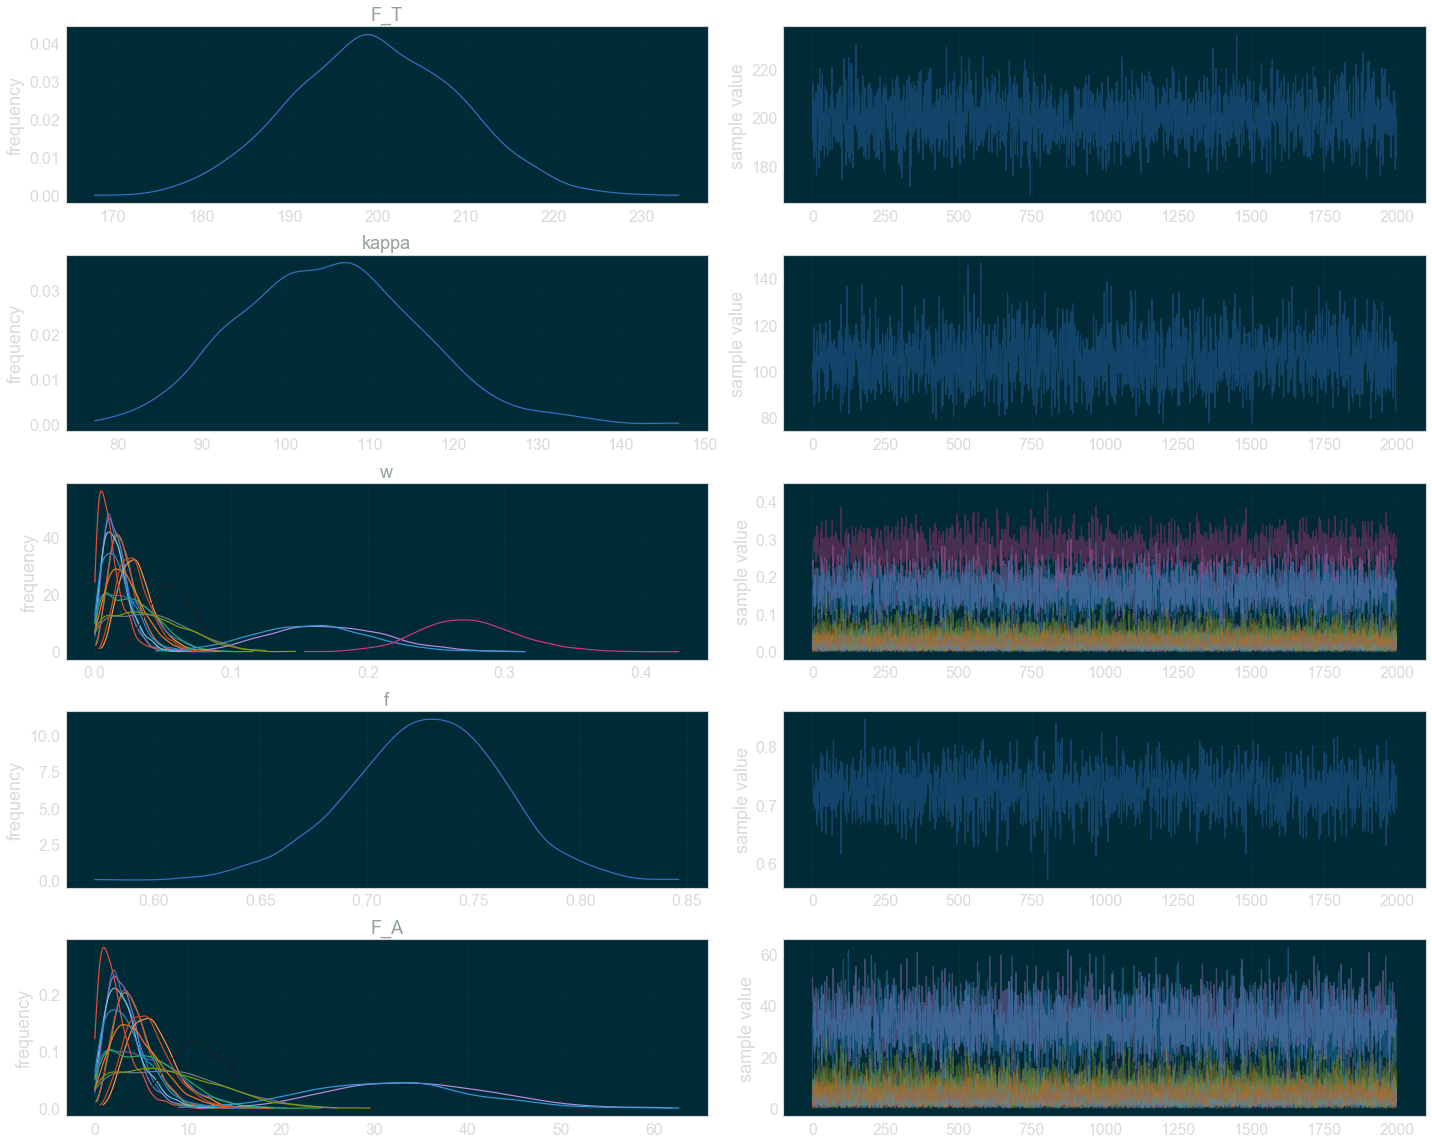

In [16]:
fig = fit.plot();
fig.set_size_inches(20, 16)
fig.tight_layout()

In [17]:
print(F[12])

34


In [20]:
# Diagnositics
sys.path.append('../stan')
import stan_utility
stan_utility.check_treedepth(fit)
stan_utility.check_div(fit)
stan_utility.check_energy(fit)

0 of 2000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 2000 iterations ended with a divergence (0.0%)
E-BFMI indicated no pathological behavior
